In [1]:
%matplotlib notebook
%matplotlib widget

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker

from tqdm.notebook import tqdm

In [2]:
# Computes the p-th power of the p-Wasserstein 1D distance between a point cloud and a density
# X - the 1D point cloud
# Y - a sorted 1D point cloud representing the density - ideally len(X) | len(Y) and len(Y) >> len(X)
# p - must be >= 1
# can return the value W_p^p and the gradient at X

def wp_1d(X, Y, p=2, return_val=True, return_grad=True):
    Y = Y[:len(Y)-len(Y)%len(X)]
    indexes = np.argsort(X)
    X2 = X[indexes]
    X3 = np.repeat(X2, len(Y)//len(X))

    wp, gradient = None, None
    
    if return_val:
        wp = np.sum(np.abs(X3-Y)**p)/len(Y)
        
    if return_grad:
        gradient = np.zeros(len(X))
        if p==2:
            gradient[indexes] = 2*(X2 - np.reshape(Y, (len(X),-1)).mean(axis=1))/len(X)
        else:
            gradient[indexes] = p*np.reshape((np.abs(X3-Y)**(p-1))*np.sign(X3-Y), (len(X),-1)).mean(axis=1)/len(X)
    
    return wp, gradient

def swp_aggregate(dirs, N, results):
    d, L = len(dirs[0]), len(dirs)
    swp = None if results[0][0] is None else 0
    grad = None if results[0][1] is None else np.zeros((N,d))
    
    for i,theta in enumerate(dirs):
        if not (swp is None):
            swp += results[i][0]/L
        if not (grad is None):
            grad = grad + np.outer(results[i][1],theta)/L
    
    return swp, grad
    
# Computes the p-th power of the p-Sliced Wasserstein distance between a point cloud
# and a density with the same projection on all directions.
# X - d-dimensional point cloud
# Y - if unif is True, sorted 1D point cloud representing the density projected on any direction 
#     else, d-dimensional point cloud representing the density
#     in both cases, ideally, len(X) | len(Y) and len(Y) >> len(X)
# p - must be >= 1
# dirs = list of test directions
# L - number of random directions - used if dirs is None
# can return the value SW_p^p and the gradient at X

def swp(X, Y, p=2, dirs=None, L=1, unif=True, return_val=True, return_grad=True, return_intermediate=False):
    if dirs is None:
        dirs = [np.random.normal(size=X.shape[1]) for i in range(L)]
    dirs = [theta / np.linalg.norm(theta) for theta in dirs]
    results = [wp_1d(X@theta, Y if unif else np.sort(Y@theta), p, return_val=return_val, return_grad=return_grad) for theta in dirs]
    swp, grad = swp_aggregate(dirs, len(X), results)
    return swp, grad, results if return_intermediate else None

Stability experiments
=================

In [3]:
def generate_2d_test_dirs(L, ofs=0):
    phi = np.linspace(0., 2*np.pi, L, endpoint=False)
    test_dirs = np.zeros((L,2))
    test_dirs[:,0] = np.cos(phi+ofs)
    test_dirs[:,1] = np.sin(phi+ofs)
    return test_dirs

def test_perturbation(X, Y, xi, width, nb_points, dirs, axfig, axplot, unif=False, title="", Yplot=None):
    if not (axfig is None):
        Yplot = Y if Yplot is None else Yplot 
        axfig.axis("equal")
        axfig.scatter(Yplot[:,0],Yplot[:,1],s=0.1, color="blue")
        axfig.scatter(X[:,0],X[:,1],s=10,color="black")
        axfig.set_title(title)
        notzero = (xi[:,0]**2 + xi[:,1]**2) > 0
        axfig.quiver(X[notzero,0], X[notzero,1], xi[notzero,0], xi[notzero,1], color="red")
        y_max = np.abs(axfig.get_ylim()).max()
        x_max = np.abs(axfig.get_xlim()).max()
        axfig.set_ylim(ymin=-y_max, ymax=y_max)
        axfig.set_xlim(xmin=-x_max, xmax=x_max)
    T = np.linspace(-width, width, nb_points)
    W = np.zeros((nb_points))
    for i,t in tqdm(enumerate(T)):
        W[i] = swp(X+t*xi, Y, dirs=dirs, unif=unif)[0]
    if not (axplot is None):
        axplot.set_title(title)
        axplot.plot(T, W)
    return T,W

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


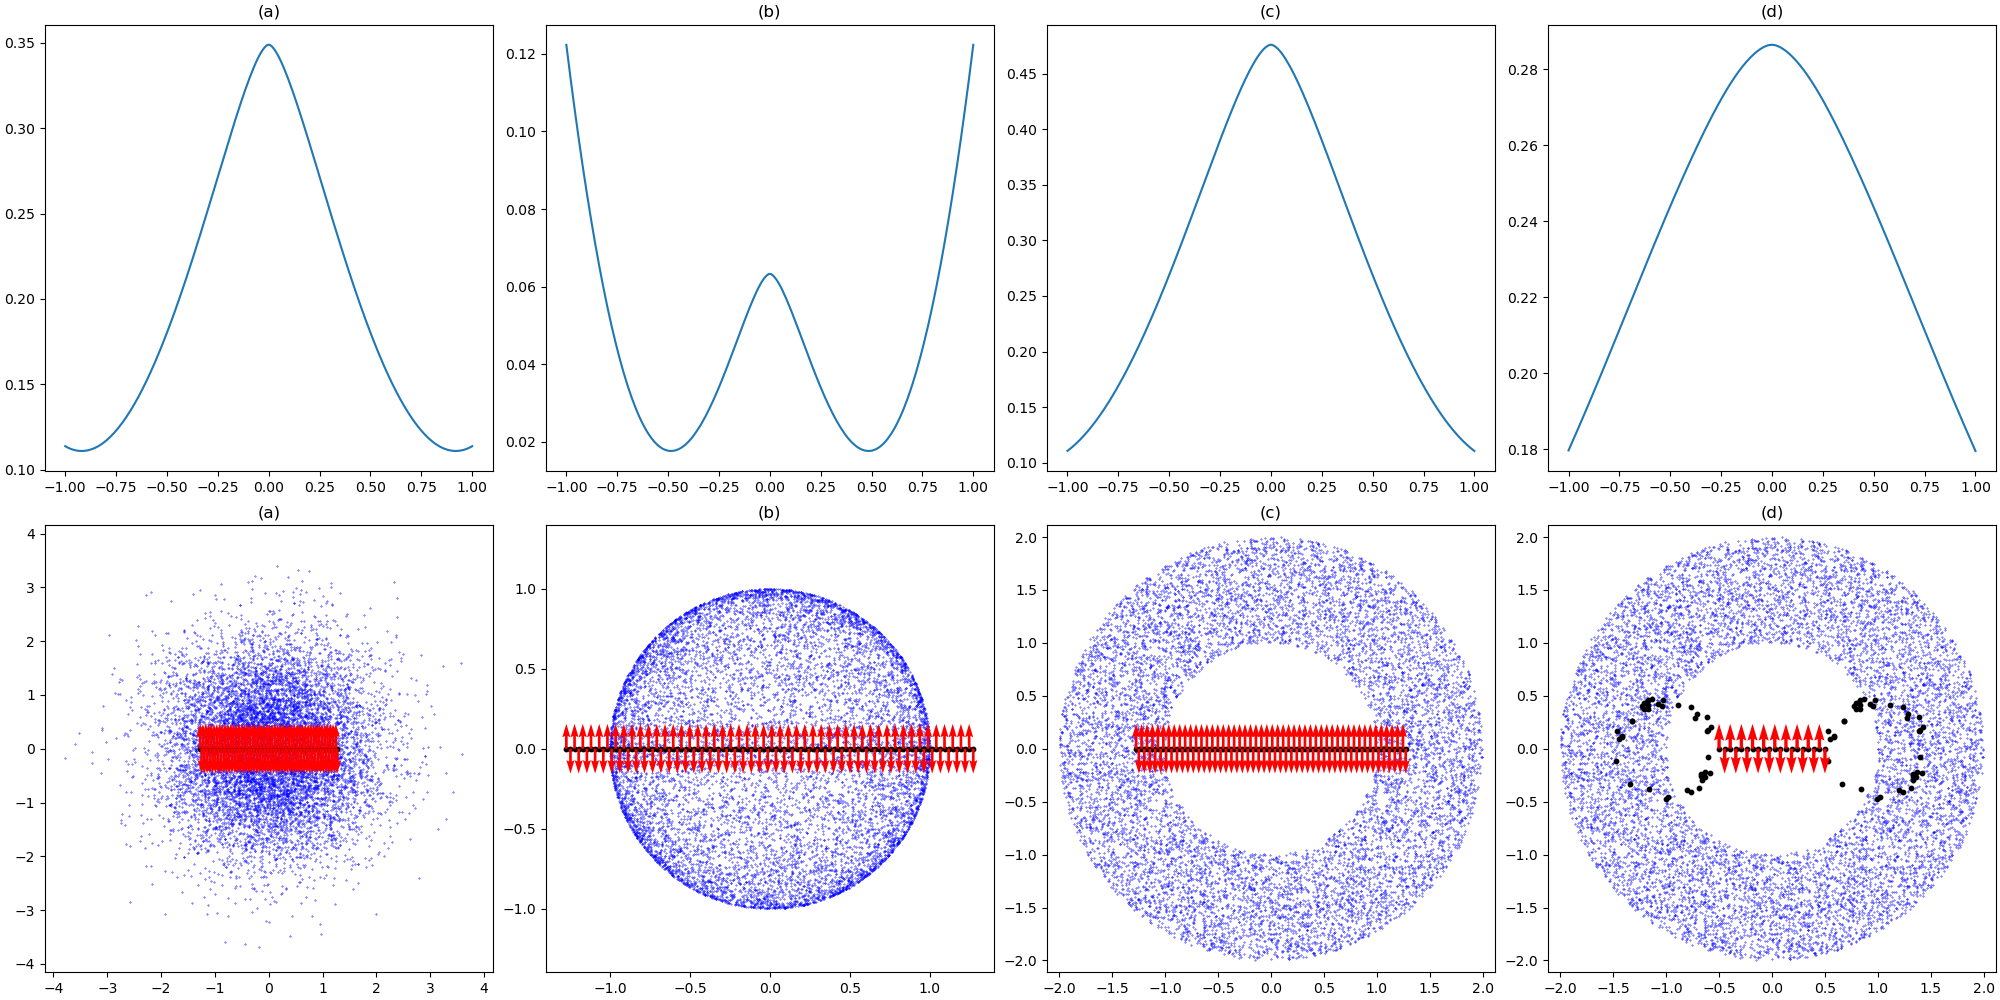

In [4]:
def shell_sampler(N, r1, r2):
    X = np.zeros((N,2))
    for i in range(N):
        X[i,:], r = np.array([r2+1.,r2+1.]), -1.0
        while (r < r1 or r > r2):
            X[i,:] = (np.random.uniform(size=2)-0.5)*2.*r2
            r = np.sqrt(X[i,:]@X[i,:])
    return X

def sliced_uniform_sampler(N):
    dirs = np.random.normal(size=(N,2))
    radius = np.sqrt(1 - (1 - np.random.uniform(size=N))**2)[:,None] # If X is a random variable of law the sliced-uniform, then the inverse cdf of |X| is x -> sqrt(1 - (1-x)^2)
    return dirs/np.linalg.norm(dirs, axis=1)[:,None] * radius

def dumbbell_cloud(N):
    N1,N2 = N//5, 2*N//5
    temp1 = np.stack((np.linspace(-0.5, 0.5, N1), np.zeros(N1)), axis=1)
    temp2 = shell_sampler(N2, 0.4, 0.5)
    X2 = np.concatenate((temp1, temp2+np.array([[-1.0,0.]]).repeat(N2,axis=0), temp2+np.array([[1.0,0.]]).repeat(N2,axis=0)), axis=0)
    xi2 = np.concatenate((np.stack((np.zeros(N1), np.tile(np.array([1.0,-1.0]), N1//2)), axis=1), np.zeros((2*N2,2))))
    return X2, xi2

N = 100
X = np.stack((np.linspace(-4./np.pi,4./np.pi,N), np.zeros(N)), axis=1)
xi = np.stack((np.zeros(N), np.tile(np.array([1.0,-1.0]), N//2)), axis=1) # Alternating up & down
X2, xi2 = dumbbell_cloud(N)

L = 100
dirs = generate_2d_test_dirs(L)

M = 100*N

Y1 = np.sort(np.random.normal(size=M*12)).reshape((M,12)).mean(axis=1) # normal distribution
Y2 = np.linspace(-1.0,1.0,M) # sliced-uniform distribution
Y3 = shell_sampler(M, 1.0, 2.0)

Y1plot = np.random.normal(size=(M,2))
Y2plot = sliced_uniform_sampler(M)

fig1, ax1 = plt.subplots(2,4,figsize=[20,10],constrained_layout=True)
_ = test_perturbation(X, Y1, xi, 1.0, 200, dirs, ax1[1,0], ax1[0,0], unif=True, title="(a)", Yplot=Y1plot)
_ = test_perturbation(X, Y2, xi, 1.0, 200, dirs, ax1[1,1], ax1[0,1], unif=True, title="(b)", Yplot=Y2plot)
_ = test_perturbation(X, Y3, xi, 1.0, 200, dirs, ax1[1,2], ax1[0,2], title="(c)")
_ = test_perturbation(X2, Y3, xi2, 1.0, 200, dirs, ax1[1,3], ax1[0,3], title="(d)")

In [5]:
ax1[1,0].set_xlim(xmin=-3, xmax=3)
ax1[1,0].set_ylim(ymin=-3, ymax=3)

ymax = np.ceil(max([ax1[0,i].get_ylim()[1] for i in range(4)])*10) # Harmonize the y ticks
for i in range(4):
    ax1[0,i].set_yticks(np.linspace(0, ymax/10.0, int(ymax)+1))

for a in ax1[0]:
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_title(a.get_title(), size=20)
    a.set_xlabel(r"$t$", size=20)
    a.set_ylabel(r"$SW^2_2$", size=20)
for a in ax1[1]:
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_title(a.get_title(), size=20)
    a.set_xlabel(r"$x$", size=20)
    a.set_ylabel(r"$y$", size=20)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

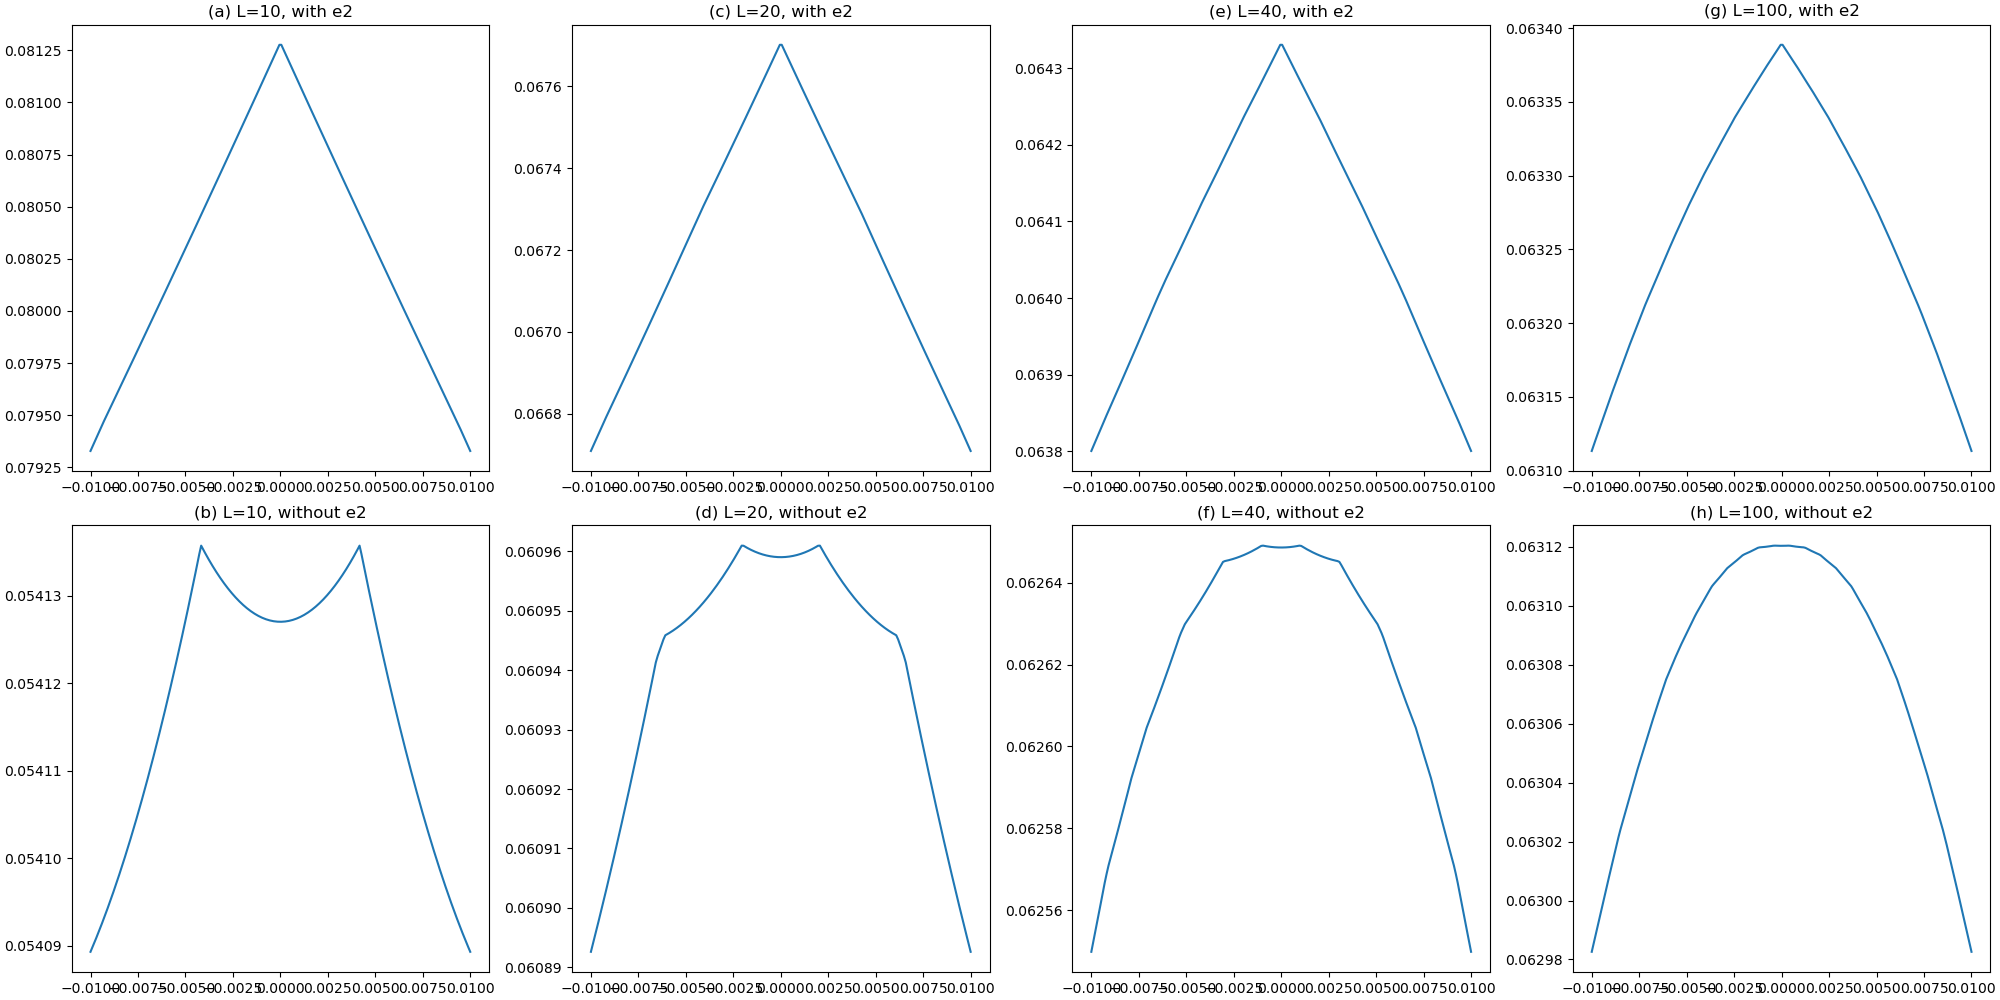

In [6]:
N = 100
X = np.stack((np.linspace(-4./np.pi,4./np.pi,N), np.zeros(N)), axis=1)
xi = np.stack((np.zeros(N), np.tile(np.array([1.0,-1.0]), N//2)), axis=1) # Alternating up & down

M = 100*N
Y2 = np.linspace(-1.0,1.0,M) # sliced-uniform distribution

nb_dirs = [10,20,40,100]
fig2, ax2 = plt.subplots(2,len(nb_dirs),figsize=[5*len(nb_dirs),10],constrained_layout=True)
    
for i,L in enumerate(nb_dirs):
    _ = test_perturbation(X, Y2, xi, 0.01, 200, generate_2d_test_dirs(L, np.pi/2), None, ax2[0,i], unif=True, title="({}) L={}, with e2".format(chr(ord('a')+2*i), L))
    _ = test_perturbation(X, Y2, xi, 0.01, 200, generate_2d_test_dirs(L, np.pi/2 + (2*np.pi)/(2*L)), None, ax2[1,i], unif=True, title="({}) L={}, without e2".format(chr(ord('a')+2*i+1), L))

In [7]:
for i,row in enumerate(ax2):
    for j,a in enumerate(row):
        a.tick_params(axis='both', which='major', labelsize=15)
        a.set_title(a.get_title(), size=20)
        a.set_xlabel(r"$t$", size=20)
        a.set_ylabel(r"$F_L$", size=20)

Gradient descent experiments
=========================

In [8]:
def descent_from(X, Y, step_size, nb_steps, dirs, axfig, axplot, unif=False, label="", title="", big_step=False):
    X2 = np.copy(X)
    T = range(nb_steps)
    W = np.zeros((nb_steps))
    for i in tqdm(T):
        val,grad,_ = swp(X2, Y, dirs=dirs, unif=unif)
        W[i] = val
        X2 -= step_size * N * grad
        
    if not (axfig is None):
        axfig.axis("equal")
        axfig.scatter(X[:,0],X[:,1],s=1,color="green")
        axfig.scatter(X2[:,0],X2[:,1],s=2,color="red")
        axfig.set_title(title, size=15)
        y_max = np.abs(axfig.get_ylim()).max()
        x_max = np.abs(axfig.get_xlim()).max()
        axfig.set_ylim(ymin=-y_max, ymax=y_max)
        axfig.set_xlim(xmin=-x_max, xmax=x_max)
    if not (axplot is None):
        if big_step:
            ylim = axplot.get_ylim()
        axplot.semilogy(T, W, label=label, scaley=(not big_step))
        if big_step:
            axplot.set_ylim(ylim)
        axplot.legend()
    return T,W

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


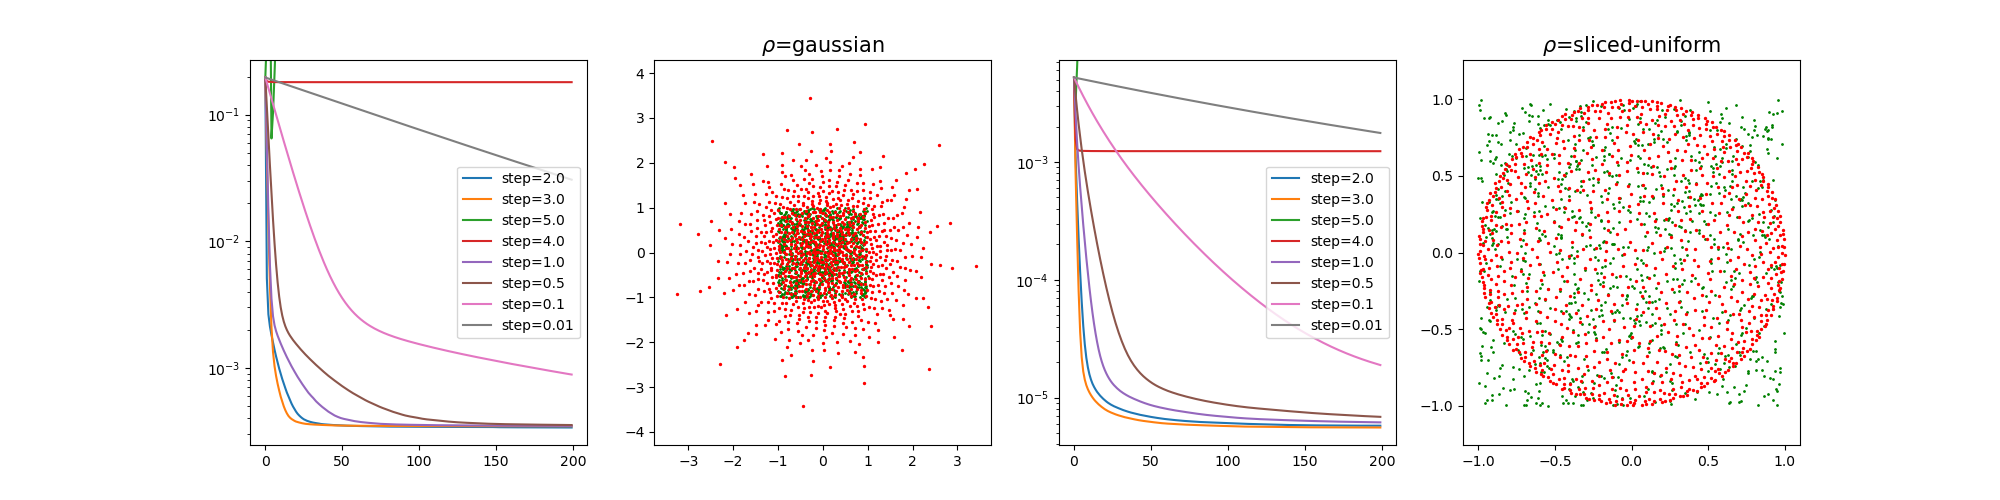

In [9]:
N = 1000
X = np.random.uniform(size=(N,2))*2.0-1.0

L = 100
dirs = generate_2d_test_dirs(L)

M = 10*N
Y1 = np.sort(np.random.normal(size=M*10)).reshape((M,10)).mean(axis=1) # normal distribution
Y2 = np.linspace(-1.0,1.0,M) # sliced-uniform distribution

steps = [2.0, 3.0, 5.0, 4.0, 1.0, 0.5, 0.1, 0.01]

fig3, ax3 = plt.subplots(1, 4, figsize=[20,5])
for i, step in enumerate(steps):
    _ = descent_from(X, Y1, step/2, 200, dirs, ax3[1] if i==0 else None, ax3[0], unif=True, label="step={}".format(step), title=r"$\rho$=gaussian", big_step=(step >= 4.0))
    _ = descent_from(X, Y2, step/2, 200, dirs, ax3[3] if i==0 else None, ax3[2], unif=True, label="step={}".format(step), title=r"$\rho$=sliced-uniform", big_step=(step >= 4.0))

In [10]:
for i,a in enumerate(ax3):
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_title(a.get_title(), size=20)
    if i%2 == 1:
        a.set_xlabel(r"$x$", size=20)
        a.set_ylabel(r"$y$", size=20)
    else:
        a.set_xlabel("Iterations", size=20)
        a.set_ylabel(r"$SW^2_2$", size=20)
        ylim = a.get_ylim()
        a.set_ylim(ymax=10.0)
        a.legend(prop={"size":15})
fig3.tight_layout()